In [ ]:
using Pkg
#pkg"add Plots, LaTeXStrings, Graphs, GraphRecipes, JLD2, Distributions, Random, PyPlot, PyCall, Clustering, SparseArrays"
#pkg"add https://github.com/Mattiatarabolo/SmallCouplingDynamicCavity.jl"
Pkg.activate(".")
Pkg.update()
Pkg.status()
Pkg.resolve()
Pkg.instantiate()

# Visualize $\mu$ and $\rho$

## Module load

In [ ]:

# === PyPlot graph utilities (replacement for GraphRecipes) ===
import PyPlot as plt
using PyCall
using Graphs
using NetworkLayout

rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 9  #9 18

function _resolve_layout(G, layout)
    if layout === :spring || layout === "spring"
        return NetworkLayout.spring(G)
    elseif layout === :stress || layout === "stress"
        return NetworkLayout.stress(G; reltols=1e-8, abstols=1e-8)
    elseif layout === :spectral || layout === "spectral"
        return NetworkLayout.spectral(G)
    elseif layout isa Function
        return layout(G)
    elseif layout !== nothing
        return layout
    else
        return NetworkLayout.spring(G)
    end
end

function draw_graph_pyplot!(ax, G::Graphs.AbstractGraph;
    pos=nothing,
    layout=:stress,
    nodesize=12.0,
    nodeedgealpha=0.6,
    nodecolors="white",
    names=nothing,
    nodeedgecolors="black",
    nodelinewidths=0.3,
    edgewidths=0.5,
    edgecolors="black",
    edgealpha=1.0,
    fontsize=7)

    pos === nothing && (pos = _resolve_layout(G, layout))

    # Convert all edgewidths, edgecolors to a matrix
    edgewidths = edgewidths isa AbstractMatrix ? edgewidths : fill(edgewidths, nv(G), nv(G))
    edgecolors = edgecolors isa AbstractMatrix ? edgecolors : fill(edgecolors, nv(G), nv(G))

    # Convert nodecolors, nodeedgecolors, nodelinewidths to a vector
    nodecolors = nodecolors isa AbstractVector ? nodecolors : fill(nodecolors, nv(G))
    nodeedgecolors = nodeedgecolors isa AbstractVector ? nodeedgecolors : fill(nodeedgecolors, nv(G))
    nodelinewidths = nodelinewidths isa AbstractVector ? nodelinewidths : fill(nodelinewidths, nv(G))

    # coordinates
    xs = [pos[i][1] for i in 1:nv(G)]
    ys = [pos[i][2] for i in 1:nv(G)]

    # Edges
    for e in edges(G)
        i = src(e); j = dst(e)
        ax.plot([xs[i], xs[j]], [ys[i], ys[j]], linewidth = edgewidths[i, j], alpha=edgealpha, c=edgecolors[i, j], zorder=0)
        #ax.plot([xs[j], xs[i]], [ys[j], ys[i]], linewidth = edgewidths[i, j], alpha=edgealpha, c=edgecolors[j, i], zorder=0)  # undirected
    end

    # Nodes
    for i in 1:nv(G)
        ax.scatter(xs[i], ys[i], s=(nodesize .* 10), c=nodecolors[i], edgecolors=nodeedgecolors[i], linewidths=nodelinewidths[i], alpha=1.0, zorder=1)
    end

    # Labels
    if names !== nothing
        for i in 1:nv(G)
            ax.text(xs[i], ys[i], string(names[i]), ha="center", va="center", fontsize=fontsize, zorder=2)
        end
    end

    ax.set_aspect("equal")
    ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(false)
    return ax
end

function draw_directed_edges!(ax, G::Graphs.AbstractGraph,
    pos,
    widthmat,
    colormat;
    alpha::Real=0.9,
    arrowsize::Real=7.0,
    curve::Real=0.18,
    minwidth::Real=0.0,
    zorder::Real=0)
    patches = plt.matplotlib.patches

    # ensure we can index pos as pos[i] => (x,y)
    xs = [pos[i][1] for i in 1:nv(G)]
    ys = [pos[i][2] for i in 1:nv(G)]

    for e in edges(G)
        i = src(e); j = dst(e)

        # i -> j
        w1 = widthmat[i,j]
        if w1 > minwidth
            c1 = colormat[i,j]
            a1 = patches.FancyArrowPatch((xs[i], ys[i]), (xs[j], ys[j]);
                arrowstyle = "-|>", mutation_scale = arrowsize,
                linewidth = w1, color = c1, alpha = alpha, zorder = zorder,
                connectionstyle = "arc3,rad=$(curve)")
            ax.add_patch(a1)
        end

        # j -> i
        w2 = widthmat[j,i]
        if w2 > minwidth
            c2 = colormat[j,i]
            a2 = patches.FancyArrowPatch((xs[j], ys[j]), (xs[i], ys[i]);
                arrowstyle = "-|>", mutation_scale = arrowsize,
                linewidth = w2, color = c2, alpha = alpha, zorder = zorder,
                connectionstyle = "arc3,rad=$(-curve)")
            ax.add_patch(a2)
        end
    end
    return ax
end


draw_directed_edges! (generic function with 2 methods)

In [311]:
using SmallCouplingDynamicCavity
using LaTeXStrings, NetworkLayout
using Graphs, NetworkLayout
using Distributions
using SparseArrays
using Random
using JLD2
using Clustering

In [312]:
function sort_by_infection_time(X, T, NV)
    inf_tuples = Dict()
    first_time_inf = ones(Int, NV).*(T+1)
    for i=1:NV
        t1 = 0
        t2 = 0
        inf = false
        for t=0:T
            if X[i,t+1]==1.0 && !inf
                t1 = t
                inf = true
            elseif X[i,t+1]==2.0 && inf
                t2 = t-1
                if !haskey(inf_tuples, i)
                    merge!(inf_tuples, Dict(i=>[(t1,t2)]))
                    first_time_inf[i] = t1
                else
                    push!(inf_tuples[i],(t1,t2))
                end
                inf = false
            else
                continue
            end
        end
        if inf
            if !haskey(inf_tuples, i)
                merge!(inf_tuples, Dict(i=>[(t1,T)]))
                first_time_inf[i] = t1
            else
                push!(inf_tuples[i],(t1,T))
            end
        end
    end
    #display(first_time_inf)
    perm = sortperm(first_time_inf)
    
    return inf_tuples, invperm(perm), perm
end


function extract_ρ_cav(i::Int, j::Int, nodes, model, γ)
    @assert i!=j
    @assert i<=length(nodes)
    @assert j<=length(nodes)

    # Initialize prior probabilities based on the expected mean number of source patients (γ)
    prior = zeros(SmallCouplingDynamicCavity.n_states(model.Disease), model.N)
    @inbounds @fastmath @simd for i in 1:model.N
        prior[1, i] = 1 - γ # x_i = S
        prior[2, i] = γ # x_i = I
    end

    # Initialize message objects
    M = SmallCouplingDynamicCavity.TransMat(model.T, model.Disease)
    ρ = SmallCouplingDynamicCavity.FBm(model.T, model.Disease)
    sumargexp = SmallCouplingDynamicCavity.SumM(model.T)

    # Compute the cavity messages
    iindex = nodes[j].∂_idx[i]
    jindex = nodes[i].∂_idx[j]
    SmallCouplingDynamicCavity.compute_sumargexp!(nodes[i], nodes, sumargexp, model)
    SmallCouplingDynamicCavity.compute_ρ!(nodes[i], iindex, nodes[j], jindex, sumargexp, M, ρ, prior, model)

    return ρ
end

function normalize!(ρ)
    @inbounds @fastmath @simd for t in 1:size(ρ.fwm)[2]
        ρ.fwm[:, t] /= sum(ρ.fwm[:, t])
        ρ.bwm[:, t] /= sum(ρ.bwm[:, t])
    end
end

function meshgrid(x,y)
    nx=length(x)
    ny=length(y)
    X=zeros(ny,nx)
    Y=zeros(ny,nx)
    for jx=1:nx
        for ix=1:ny
            X[ix,jx]=x[jx]
            Y[ix,jx]=y[ix]
        end
    end
    return X, Y
end

meshgrid (generic function with 1 method)

## $\rho$ visualization

### Data loading

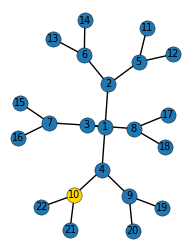

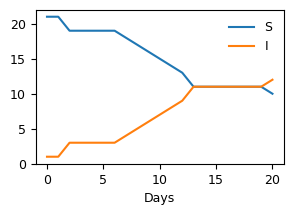

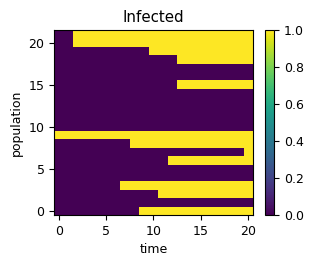

Matrix{Int8} (alias for Array{Int8, 2})

In [326]:
data = load("rho_supershort_tree.jld2")
G = data["G"]
NV = nv(G)
config = data["config"]
T = data["T"]
λ₀ = data["lambda"]
γ = 1/NV # Patient zero probability
observed = data["observed"]

isource = findall(x->x==1.0,config[:,1])

cols = ["tab:blue" for _ in 1:NV]
cols[isource] .= "gold"

fig, ax = plt.subplots(1,1, figsize=(3.0, 3.0))
draw_graph_pyplot!(ax, G; names=1:NV, nodecolors=cols, layout=:stress, edgewidths=1)
plt.display(fig)

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0),config), dims = 1), dims = 1)
#nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)

fig, ax = plt.subplots(1,1, figsize=(3.2, 2.0))
ax.plot(0:T, nrS, label="S")
ax.plot(0:T, nrI, label="I")
ax.set_xlabel("Days")
ax.legend(loc="best", frameon=false)
plt.display(fig)


# display epidemy
fig, ax = plt.subplots(1,1, figsize=(3.2, 2.4))
cax = ax.imshow(config, aspect="auto", origin="lower")
ax.set_title("Infected")
ax.set_xlabel("time")
ax.set_ylabel("population")
fig.colorbar(cax, ax=ax)
plt.display(fig)
typeof(config)

### Inference SCDC-- autoinfection, $\mu$ cutoff

In [327]:
# computational constants
epsconv = 5e-5 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.0 # damping factor
μ_cutoff = -Inf
ε_autoinf = 0.0

# define the observation probability
function obsprob(Ob, x)
    if Ob == -1
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SI(ε_autoinf, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

report (generic function with 1 method)

xᵢ(n=8) = 0
[(1, 8)]
i = 1 ε = 1.0
i = 2 ε = 0.8489180809232602
i = 3 ε = 0.5659622567887137
i = 4 ε = 0.09549750691191422
i = 5 ε = 0.033337050217214004
i = 6 ε = 0.0
xᵢ(t=12) = 1
[(1, 12)]
i = 1 ε = 0.9545454545454546
i = 2 ε = 0.7862022077387423
i = 3 ε = 0.5659622567887137
i = 4 ε = 0.12406569857942684
i = 5 ε = 0.11598704952087296
i = 6 ε = 0.0


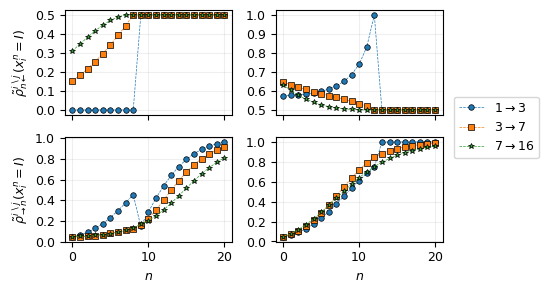

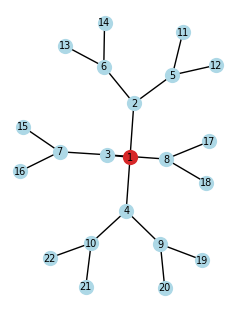

In [344]:
mark = ["o", "s", "*"]
col = ["C0","C1", "C2"]

paths = [(1,3), (3,7), (7,16)]

fig, ax = plt.subplots(2, 2, figsize=(4.6, 3), sharex=true, tight_layout=true)

######## Observed Susceptible ##############
t_obs = 8 #ceil(Int,T/2)+

# generate observations
obsmat_S = ones(Int8, NV, T+1) * (-1)
obslist_S = Vector{Tuple{Int,Int}}()
for iₗ in observed
    obsmat_S[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    println("xᵢ(n=$(t_obs)) = $(config[iₗ, t_obs+1])")
    push!(obslist_S, (iₗ, ceil(Int,t_obs)))
end
println(obslist_S)

# insert the observations into the model structure
model.obsmat .= obsmat_S

nodes_S = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

for (index,(i,j)) in enumerate(paths)
    ρ = extract_ρ_cav(i, j, nodes_S, model, γ)
    normalize!(ρ)
    ax[1].plot(0:T, ρ.bwm[2,:], label=L"%$i \rightarrow %$j", linestyle="--", color=col[index], linewidth=.5, marker=mark[index], markersize=4, markeredgecolor="black", markeredgewidth=.5)
    ax[2].plot(0:T, ρ.fwm[2,:], linestyle="--", color=col[index], linewidth=.5, marker=mark[index], markersize=4, markeredgecolor="black", markeredgewidth=.5)
end
ax[2].set_xlabel(L"n")
ax[1].set_ylabel(L"\tilde{\rho}_{n\leftarrow}^{i\setminus j}(x_i^n=I)")
ax[2].set_ylabel(L"\tilde{\rho}_{\rightarrow n}^{i\setminus j}(x_i^n=I)")
ax[1].set_yticks(0:.1:.5)
ax[2].set_yticks(0:.2:1)
#ax[1].set_ylabel(L"\rho_{t\leftarrow}^{i\setminus j}(x_i^t=I)")
#ax[1].legend()



######### Observed Infected ###################
t_obs = 12 #ceil(Int,T/2)+

# generate observations
obsmat_I = ones(Int8, NV, T+1) * (-1)
obslist_I = Vector{Tuple{Int,Int}}()
for iₗ in observed
    obsmat_I[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    println("xᵢ(t=$(t_obs)) = $(config[iₗ, t_obs+1])")
    push!(obslist_I, (iₗ, ceil(Int,t_obs)))
end
println(obslist_I)

# insert the observations into the model structure
model.obsmat .= obsmat_I

nodes_I = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

for (index,(i,j)) in enumerate(paths)
    ρ = extract_ρ_cav(i, j, nodes_I, model, γ)
    normalize!(ρ)
    ax[3].plot(0:T, ρ.bwm[2,:], linestyle="--", color=col[index], linewidth=.5, marker=mark[index], markersize=4, markeredgecolor="black", markeredgewidth=.5)
    ax[4].plot(0:T, ρ.fwm[2,:], linestyle="--", color=col[index], linewidth=.5, marker=mark[index], markersize=4, markeredgecolor="black", markeredgewidth=.5)
end
ax[4].set_xlabel(L"n")
ax[3].set_yticks(.5:.1:1)
ax[4].set_yticks(0:.2:1)


ax[1].grid(alpha=.2)
ax[2].grid(alpha=.2)
ax[3].grid(alpha=.2)
ax[4].grid(alpha=.2)

fig.legend(
    loc="center left",       # Position the legend at the top center
    bbox_to_anchor=(.98, .563),  # Position slightly above the subplots
    ncol=1,                    # Horizontal arrangement of item
)

fig.savefig("rhos_norm_plot2.svg", bbox_inches="tight")
plt.display(fig)



########### graph plot #####################

uniform_size = 1  # Adjust this value to change the size of nodes
node_sizes = fill(uniform_size, nv(G))  # Uniform size for all nodes
cols = ["lightblue" for _ in 1:NV]
cols[observed] .= "tab:red"

fig, ax = plt.subplots(1,1, figsize=(3.0, 3.0), layout="constrained")
draw_graph_pyplot!(ax, G; names=1:NV, nodecolors=cols, layout=:stress, edgewidths=1, nodeedgealpha=0.0, nodelinewidths=0.0)
plt.display(fig)

fig.savefig("rhos_backward_graph2.svg", bbox_inches="tight")

In [338]:
(8, 1) ∈ edges(G)

false

## $\mu$ visualization

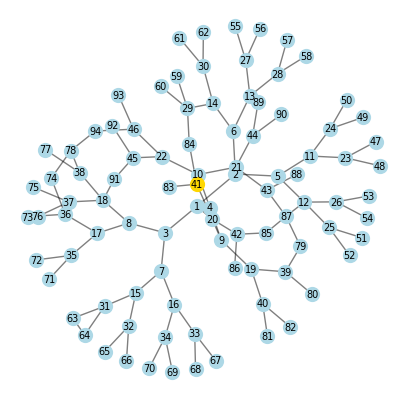

In [316]:
data = load("mus_graph.jld2")

G = data["G"]
isource = data["isource"]
NV = nv(G)
Random.seed!(1998)
cols = ["lightblue" for _ in 1:NV]
cols[isource] .= "gold"

fig, ax = plt.subplots(1,1, figsize=(5.0, 5.0))
draw_graph_pyplot!(ax, G; names=1:NV, nodecolors=cols, layout=:stress, edgewidths=1, edgealpha=0.5, nodeedgealpha=0.0, nodelinewidths=0.0)
plt.display(fig)

fig.savefig("musgraph_num.svg", bbox_inches="tight")

T = data["T"]
λ₀ = data["lambda"]
γ = 1/NV # Patient zero probability
config = data["config"]
observed1 = data["observed1"]
observed2 = data["observed2"]

mst = SimpleDiGraphFromIterator(kruskal_mst(G))
D = ones(NV,NV) - adjacency_matrix(mst) - adjacency_matrix(mst)' 
cluster_order = hclust(D).order
inv_clust = [findall(x->x==i,cluster_order)[1] for i in 1:NV]
inf_tuple, _, _ = sort_by_infection_time(config, T, NV);

### Generation of observations

In [317]:
t_obs = 25

println(config[12,t_obs+1])
println(config[8,t_obs+1])

1
0


### Inference SCDC-- autoinfection, $\mu$ cutoff

In [318]:
# computational constants
epsconv = 1e-13 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.0 # damping factor
μ_cutoff = -Inf
ε_autoinf = 0.0

# define the observation probability
function obsprob(Ob, x)
    if Ob == -1
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SI(ε_autoinf, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

report (generic function with 1 method)

In [319]:
# generate observations
obsmat1 = ones(NV, T+1) * (-1.0)
obslist1 = []
for iₗ in observed1
    obsmat1[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    push!(obslist1, (iₗ, ceil(Int,t_obs)))
end

# insert the observations into the model structure
model.obsmat .= obsmat1

nodes1 = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob1 = ones(NV, T+1)
for node in nodes1
    marg_prob1[node.i,:] .= node.marg.m[2,:]
end



# generate observations
obsmat2 = ones(NV, T+1) * (-1.0)
obslist2 = []
for iₗ in observed2
    obsmat2[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    push!(obslist2, (iₗ, ceil(Int,t_obs)))
end

# insert the observations into the model structure
model.obsmat .= obsmat2

nodes2 = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob2 = ones(NV, T+1)
for node in nodes2
    marg_prob2[node.i,:] .= node.marg.m[2,:]
end



i = 1 ε = 0.9893617021276596
i = 2 ε = 0.932157742225674
i = 3 ε = 0.7448865453320717
i = 4 ε = 0.5223123538817871
i = 5 ε = 0.3815432732838642
i = 6 ε = 0.24115192725602758
i = 7 ε = 0.14523354903766322
i = 8 ε = 0.05463657413890444
i = 9 ε = 0.022697278872410465
i = 10 ε = 0.014067799690675065
i = 11 ε = 0.0098705136296528
i = 12 ε = 0.004902850468115338
i = 13 ε = 0.0015570159348837764
i = 14 ε = 0.0012417089405110104
i = 15 ε = 0.0009230761261114218
i = 16 ε = 0.000683669906885287
i = 17 ε = 0.00021814993934970994
i = 18 ε = 0.00016484326148002992
i = 19 ε = 6.690872624104394e-5
i = 20 ε = 3.7795989752842374e-5
i = 21 ε = 2.9076225809776535e-5
i = 22 ε = 1.445734398108911e-5
i = 23 ε = 1.0030768965996195e-5
i = 24 ε = 5.145349471880056e-6
i = 25 ε = 3.7316276680909866e-6
i = 26 ε = 2.523883525784587e-6
i = 27 ε = 1.6650402050455426e-6
i = 28 ε = 1.4095145502990292e-6
i = 29 ε = 1.0950516874386196e-6
i = 30 ε = 3.639856186454793e-7
i = 31 ε = 1.1179760439627984e-7
i = 32 ε = 8.06926

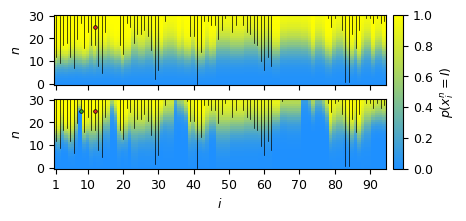

In [320]:
cols = ["tab:green", "tab:red", "black"]

# Custom color gradient
color1 = "dodgerblue"  # Starting color
color2 = "yellow"      # Ending color
# Create a colormap using LinearSegmentedColormap
cm = plt.matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", [color1, color2])

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(4.6, 2), sharex=true)  # Adjust layout

# Define axes
x_edges = .5:(NV + .5)  # Edges for x-axis (0.5 to NV + 0.5)
y_edges = -.5:T+.5  # Edges for y-axis (0 to T)
# Create X, Y coordinate matrices
X, Y = meshgrid(x_edges, y_edges)

# First heatmap (p1)
ax1 = axes[1]
p1 = ax1.pcolor(X, Y, marg_prob1', cmap=cm, vmin=0, vmax=1, edgecolors="none")
ax1.set_ylim(-.5, T+.5)
ax1.set_xlim(.5, NV+.5)
ax1.set_ylabel(L"n")
ax1.set_yticks(0:10:T)

# Plot infection times (p1)
for (i, inf_time_list) in inf_tuple
    for inf_time in inf_time_list
        ax1.plot([i, i], [inf_time[1] - 0.1, inf_time[2] + 0.1], c="black", lw=.5, zorder=1)
    end
end

# Plot observations (p1)
for (i, t) in obslist1
    ax1.scatter(i, t, s=7, c=cols[ceil(Int, config[i, t + 1]) + 1], edgecolor="black", linewidths=0.5, zorder=2)
end

# Second heatmap (p2)
ax2 = axes[2]
p2 = ax2.pcolor(X, Y, marg_prob2', cmap=cm, vmin=0, vmax=1, edgecolors="none",)
ax2.set_ylim(-.5, T+.5)
ax2.set_xlim(.5, NV+.5)
ax2.set_xlabel(L"i")
ax2.set_ylabel(L"n")
ax2.set_xticks(vcat([1], collect(10:10:NV)))
ax2.set_yticks(0:10:T)

# Plot infection times (p2)
for (i, inf_time_list) in inf_tuple
    for inf_time in inf_time_list
        ax2.plot([i, i], [inf_time[1]-.4, inf_time[2]+.4], c="black", lw=.5, zorder=1)
    end
end

# Plot observations (p2)
for (i, t) in obslist2
    ax2.scatter(i, t, s=7, c=cols[ceil(Int, config[i,t+1])+1], edgecolor="black", linewidths=0.5, zorder=2)
end

# Add a single shared colorbar
cbar = fig.colorbar(p2, ax=axes, orientation="vertical", fraction=0.05, pad=0.02, aspect=15)
cbar.set_label(L"p(x_i^n=I)")
cbar.set_ticks(0:.2:1)

plt.display(fig)
# Save the plot
fig.savefig("heatmap_plot.png", format="png", bbox_inches="tight", dpi=2000)


In [321]:
function norm_μ(i::Int,j::Int,nodes::Vector, t::Int)
    iindex = nodes[j].∂_idx[i]  #calculate the norm of μ at node i for the j_th coNVection
    abs(nodes[j].cavities[iindex].μ[t+1])
end

function check_μ_nonzero(i::Int,j::Int,nodes::Vector, t::Int)
    iindex = nodes[j].∂_idx[i]  #calculate the norm of μ at node i for the j_th coNVection
    abs(nodes[j].cavities[iindex].μ[t+1]) >= 1e-5
end

check_μ_nonzero (generic function with 1 method)

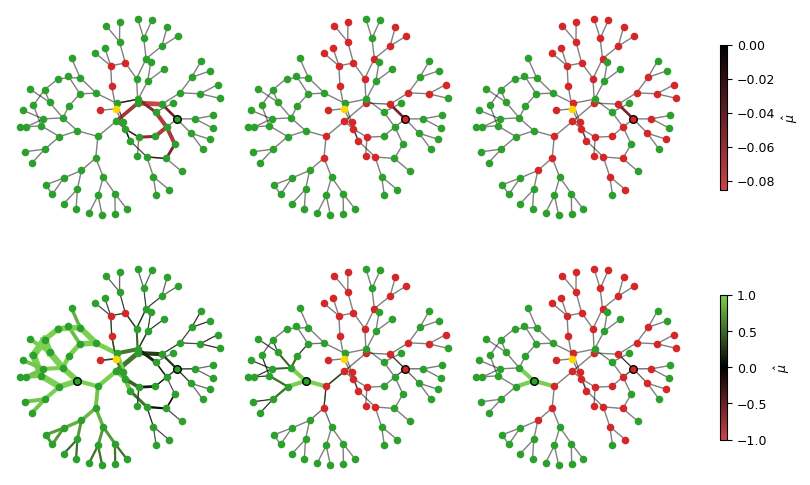

μ1 in [-0.0854397016206012, 0.0]
μ2 in [-0.34916969143306403, 1.0000000000000002]


In [322]:
times = [t_obs-20, t_obs-5, t_obs-1]

fig, axs = plt.subplots(2, 3, figsize=(8, 5), layout="constrained")  # Adjust layout

mumax1, mumin1 = 0.0, 0.0
for i in 1:NV
    for cav in nodes1[i].cavities
        mumax1 = max(mumax1, maximum(cav.μ[times .+ 1]))
        mumin1 = min(mumin1, minimum(cav.μ[times .+ 1]))
    end
end

mumax2, mumin2 = 0.0, 0.0
for i in 1:NV
    for cav in nodes2[i].cavities
        mumax2 = max(mumax2, maximum(cav.μ[times .+ 1]))    
        mumin2 = min(mumin2, minimum(cav.μ[times .+ 1]))
    end
end

println("μ1 in [", mumin1, ", ", mumax1, "]")
println("μ2 in [", mumin2, ", ", mumax2, "]")

Colors = plt.matplotlib.colors
viridis = plt.cm.get_cmap("viridis")
inferno = plt.cm.get_cmap("inferno")
cm2 = plt.matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", [inferno(0.55), "black", viridis(0.8)])
cm1 = plt.matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", [cm2(0.0), cm2(0.5)])
# TwoSlopeNorm centers the colormap at `vcenter`
norm1 = Colors.Normalize(vmin=mumin1, vmax=(mumax1 == 0.0 ? 1e-4 : mumax1))#, vcenter=0.0)
norm2 = Colors.TwoSlopeNorm(vmin=-mumax2, vmax=mumax2, vcenter=0.0)

function colormapcustom(val, cm, norm)
    return cm(norm(val))
end

######## 1 obs ##############
for (idxt, t) in enumerate(times)
    μ1 = zeros(NV,NV)
    μval1 = zeros(NV,NV)
    for e in edges(G)
        i = src(e)
        j = dst(e)
        μ1[j,i] += norm_μ(i,j,nodes1, t)
        μ1[i,j] += norm_μ(j,i,nodes1, t)
        μval1[j,i] += nodes1[i].cavities[nodes1[i].∂_idx[j]].μ[t+1] + nodes1[j].cavities[nodes1[j].∂_idx[i]].μ[t+1]
        μval1[i,j] += nodes1[i].cavities[nodes1[i].∂_idx[j]].μ[t+1] + nodes1[j].cavities[nodes1[j].∂_idx[i]].μ[t+1]
    end
    #μval1 = (μval1)

    μnz1 = zeros(NV,NV)
    for e in edges(G)
        i = src(e)
        j = dst(e)
        μnz1[j,i] += check_μ_nonzero(i,j,nodes1, t)*1.8 + check_μ_nonzero(j,i,nodes1, t)*1.8
        μnz1[i,j] += check_μ_nonzero(i,j,nodes1, t)*1.8 + check_μ_nonzero(j,i,nodes1, t)*1.8
    end
    μnz1 .+= 0.5

    cols = [config[i,t+1]==1.0 ? "tab:red" : "tab:green" for i=1:NV]
    cols[isource] .= "gold"
    obswidth = [0.0 for _ in 1:NV]
    obswidth[observed1] .= 1.0
    markcol = ["white" for _ in 1:NV]
    markcol[observed1] .= "black"
    markalpha = [0.0 for _ in 1:NV]
    markalpha[observed1] .= 1.0

    ax = axs[1, idxt]
    draw_graph_pyplot!(ax, G; edgewidths=1, nodecolors="white", nodeedgecolors="white", nodeedgealpha=0.0, layout=:stress, nodesize=0.0, nodelinewidths=0.0, edgecolors="black", edgealpha=0.5)
    draw_graph_pyplot!(ax, G; edgewidths=μ1 .* 40, nodecolors=cols, nodeedgecolors=markcol, nodeedgealpha=0.0, layout=:stress, nodesize=3.0, nodelinewidths=obswidth, edgecolors=[colormapcustom(val, cm1, norm1) for val in μval1])

    ######## 2 obs ##############
    μ2 = zeros(NV,NV)
    μval2 = zeros(NV,NV)
    for e in edges(G)
        i = src(e)
        j = dst(e)
        μ2[j,i] += norm_μ(i,j,nodes2,t) + norm_μ(j,i,nodes2,t)
        μ2[i,j] += norm_μ(i,j,nodes2,t) + norm_μ(j,i,nodes2,t)
        μval2[j,i] += nodes2[i].cavities[nodes2[i].∂_idx[j]].μ[t+1] + nodes2[j].cavities[nodes2[j].∂_idx[i]].μ[t+1]
        μval2[i,j] += nodes2[i].cavities[nodes2[i].∂_idx[j]].μ[t+1] + nodes2[j].cavities[nodes2[j].∂_idx[i]].μ[t+1]
    end

    μnz2 = zeros(NV,NV)
    for e in edges(G)
        i = src(e)
        j = dst(e)
        μnz2[j,i] += check_μ_nonzero(i,j,nodes2,t).*1.8 + check_μ_nonzero(j,i,nodes2,t).*1.8
        μnz2[i,j] += check_μ_nonzero(i,j,nodes2,t).*1.8 + check_μ_nonzero(j,i,nodes2,t).*1.8
    end
    μnz2 .+= 0.5

    cols = [config[i,t+1]==1.0 ? "tab:red" : "tab:green" for i=1:NV]
    cols[isource] .= "gold"
    obswidth = [0.0 for _ in 1:NV]
    obswidth[observed2] .= 1.0
    markcol = ["white" for _ in 1:NV]
    markcol[observed2] .= "black"
    markalpha = [0.0 for _ in 1:NV]
    markalpha[observed2] .= 1.0

    ax = axs[2, idxt]
    draw_graph_pyplot!(ax, G; edgewidths=1, nodecolors="white", nodeedgecolors="white", nodeedgealpha=0.0, layout=:stress, nodesize=0.0, nodelinewidths=0.0, edgecolors="black", edgealpha=0.5)
    draw_graph_pyplot!(ax, G; edgewidths=μ2 .* 3, nodecolors=cols, nodeedgecolors=markcol, nodeedgealpha=0.0, layout=:stress, nodesize=3.0, nodelinewidths=obswidth, edgecolors=[colormapcustom(val, cm2, norm2) for val in μval2])
end

# Add colorbars to the right of each row
# Create dummy mappable to feed colorbar
sm1 = plt.matplotlib.cm.ScalarMappable(norm=norm1, cmap=cm1)
sm1.set_array([])  # required by Matplotlib API
# Add colorbar to this subplot only
cbar1 = fig.colorbar(sm1, ax=axs[1, :], orientation="vertical", location="right", shrink=0.6)
cbar1.set_label(L"\hat\mu")   # LaTeX label
# Create dummy mappable to feed colorbar
sm2 = plt.matplotlib.cm.ScalarMappable(norm=norm2, cmap=cm2)
sm2.set_array([])  # required by Matplotlib API
cbar2 = fig.colorbar(sm2, ax=axs[2, :], orientation="vertical", location="right", shrink=0.6)
cbar2.set_label(L"\hat\mu")   # LaTeX label

plt.display(fig)
fig.savefig("mus_active2.svg", bbox_inches="tight")


In [324]:
println(times)

[5, 20, 24]
